In [1]:
import dask, concurrent.futures, time, warnings, os, re, pickle
from osgeo import gdal
import os
import glob
import requests as r
import pandas as pd
import geopandas as gpd
import numpy as np
import rasterio as rio
import rioxarray as riox
import time
import xarray as xr
from urllib.request import urlopen
from xml.etree.ElementTree import parse,fromstring
from pandas import to_datetime
from rasterio.crs import CRS
from datetime import datetime, timedelta
from netrc import netrc
from pyproj import Proj
from src.hls_funcs import fetch
from src.hls_funcs.masks import mask_hls, shp2mask, bolton_mask
from src.hls_funcs.indices import ndvi_func
from src.hls_funcs.smooth import smooth_xr, despike_ts_xr
import cartopy.crs as ccrs
from rasterio.plot import show
from src.hls_funcs.predict import pred_bm, pred_bm_se, pred_cov
import dask.diagnostics
import matplotlib.pyplot as plt
import gc


In [2]:
#wkDIR = '/project/cper_neon_aop/hls_nrt/'
#outDIR = '/90daydata/cper_neon_aop/hls_nrt/' + prefix

wkDIR = os.getcwd()
outDIR_base = 'data/hls_nrt/'

cluster_loc = 'local'

In [3]:
yr = 2022

#prefix = 'redtop' 
prefix = 'cper'

if prefix == 'cper': 
    aoi_f = os.path.join('data/ground/cper_pastures_2017_clip.shp')
    df_aoi = gpd.read_file(aoi_f)
    subunit_name_old = 'Past_Name_'
    subunit_name = 'Pasture'
elif prefix == 'redtop':
    from src.utils.convert import kmz_to_shp
    df_aoi = kmz_to_shp('data/ground/RedTop_Boundary.kmz', 'data/ground/')
    df_aoi = df_aoi.to_crs(epsg=32613)
    subunit_name_old = None
    subunit_name = None

outDIR = os.path.join(outDIR_base, prefix)

mod_bm = pickle.load(open('src/models/CPER_HLS_to_VOR_biomass_model_lr_simp.pk', 'rb'))
mod_cov = pickle.load(open('src/models/CPER_HLS_to_LPI_cover_pls_binned_model.pk', 'rb'))

/home/spkearney/miniconda3/envs/hls_nrt_env/lib/python3.10/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator PLSRegression from version 0.24.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [4]:
os.chdir(wkDIR)
if cluster_loc == 'local':
    print('   setting up Local cluster...')
    from dask.distributed import LocalCluster, Client
    import dask
    aws=False
    fetch.setup_env(aws=aws)
    smth_chunks = {'y': 30, 'x': 30, 'time':-1}
    cluster = LocalCluster(n_workers=8, threads_per_worker=2)
    client = Client(cluster)
    display(client)
elif cluster_loc == 'coiled':
    import coiled
    aws=True
    fetch.setup_env(aws=aws)
    smth_chunks = {'y': 10, 'x': 10, 'time':-1}
    s3_cred = fetch.setup_netrc(creds=['spkearney', '1mrChamu'], aws=aws)
    coiled.create_software_environment(
    name="hls_cog_coiled",
    conda="hls_cog_coiled_env.yaml")
    cluster = coiled.Cluster(
        name="hls_cog_coiled",
        software="kearney-sp/hls_cog_coiled",
        n_workers=5,
        worker_cpu=2,
        scheduler_cpu=2,
        backend_options={"region": "us-west-2"},
        environ=dict(GDAL_DISABLE_READDIR_ON_OPEN='FALSE', 
                   #AWS_NO_SIGN_REQUEST='YES',
                   GDAL_MAX_RAW_BLOCK_CACHE_SIZE='200000000',
                   GDAL_SWATH_SIZE='200000000',
                   VSI_CURL_CACHE_SIZE='200000000',
                   CPL_VSIL_CURL_ALLOWED_EXTENSIONS='TIF',
                   GDAL_HTTP_UNSAFESSL='YES',
                   GDAL_HTTP_COOKIEFILE=os.path.expanduser('~/cookies.txt'),
                   GDAL_HTTP_COOKIEJAR=os.path.expanduser('~/cookies.txt'),
                   AWS_REGION='us-west-2',
                   AWS_SECRET_ACCESS_KEY=s3_cred['secretAccessKey'],
                   AWS_ACCESS_KEY_ID=s3_cred['accessKeyId'],
                   AWS_SESSION_TOKEN=s3_cred['sessionToken'])
    )
    client = Client(cluster)
    display(client)
elif cluster_loc == 'hpc':
    from dask.distributed import LocalCluster, Client
    import dask_jobqueue as jq
    import dask
    from jupyter_server import serverapp
    
    # get the server address for porting
    try:
        jupServer = [x for x in serverapp.list_running_servers()][0]
    except IndexError:
        # manually copy/paste the server address
        jupServer = {'base_url': '/node/ceres19-compute-98-eth.scinet.local/17710/'}
    print('   setting up moderate cluster on HPC...')
    aws=False
    fetch.setup_env(aws=aws)
    smth_chunks = {'y': 10, 'x': 10, 'time':-1}
    dask.config.set({'distributed.dashboard.link': jupServer['base_url'] + 'proxy/{port}/status'})
    partition='short',#'short','debug', 'mem', 'mem-low',
    num_processes = 4
    num_threads_per_processes = 2
    mem = 2.5*num_processes*num_threads_per_processes
    n_cores_per_job = num_processes*num_threads_per_processes
    clust = jq.SLURMCluster(queue=partition,
                            processes=num_processes,
                            cores=n_cores_per_job,
                            memory=str(mem)+'GB',
                            interface='ib0',
                            #interface='enp24s0f0',
                            local_directory='$TMPDIR',
                            death_timeout=30,
                            walltime='02:00:00',
                            job_extra=["--output=/dev/null","--error=/dev/null"])
    client=Client(clust)
    #Scale Cluster 
    num_jobs=20
    clust.scale(jobs=num_jobs)
    try:
        client.wait_for_workers(n_workers=num_jobs*num_processes, timeout=60)
    except dask.distributed.TimeoutError as e:
        print(str(num_jobs*num_processes) + ' workers not available. Continuing with available workers.')
        #print(e)
        pass
    display(client)

if not os.path.exists(outDIR):
    os.mkdir(outDIR)

if subunit_name_old is not None:
    df_aoi = df_aoi.rename(columns={subunit_name_old: subunit_name})
if subunit_name is not None:
    df_aoi = df_aoi.dissolve(by=subunit_name).reset_index()

start_date = str(yr - 1) + "-11-01"
end_date = str(yr + 1) + "-03-01"

# set the date range for analysis
date_rng = pd.date_range(start=start_date, end=end_date)
date_rng = date_rng[date_rng <= datetime.today()]

   setting up Local cluster...


2022-06-16 11:56:09,954 - distributed.diskutils - INFO - Found stale lock file and directory '/mnt/c/Users/TBGPEA-Sean/git_repos/hls_nrt/dask-worker-space/worker-8butcwi_', purging
2022-06-16 11:56:09,965 - distributed.diskutils - INFO - Found stale lock file and directory '/mnt/c/Users/TBGPEA-Sean/git_repos/hls_nrt/dask-worker-space/worker-my_oi0ww', purging
2022-06-16 11:56:09,975 - distributed.diskutils - INFO - Found stale lock file and directory '/mnt/c/Users/TBGPEA-Sean/git_repos/hls_nrt/dask-worker-space/worker-odr8pkj1', purging
2022-06-16 11:56:09,985 - distributed.diskutils - INFO - Found stale lock file and directory '/mnt/c/Users/TBGPEA-Sean/git_repos/hls_nrt/dask-worker-space/worker-p0lypfay', purging
2022-06-16 11:56:09,994 - distributed.diskutils - INFO - Found stale lock file and directory '/mnt/c/Users/TBGPEA-Sean/git_repos/hls_nrt/dask-worker-space/worker-qzqk6uu4', purging
2022-06-16 11:56:10,013 - distributed.diskutils - INFO - Found stale lock file and directory '/

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 16,Total memory: 15.50 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:44321,Workers: 8
Dashboard: http://127.0.0.1:8787/status,Total threads: 16
Started: Just now,Total memory: 15.50 GiB
Comm: tcp://127.0.0.1:37797,Total threads: 2
Dashboard: http://127.0.0.1:37761/status,Memory: 1.94 GiB
Nanny: tcp://127.0.0.1:33079,


In [5]:
t00 = time.time()
nc_flist = list(filter(os.path.isfile, 
                    glob.glob(os.path.join(outDIR,
                              prefix + 
                              '_hls_tmp/' + 'hls_ds_' + str(yr) + '*.nc'))))
if len(nc_flist) > 0:
    nc_flist.sort(key=lambda x: os.path.getctime(x))
    nc_f = nc_flist[-1]
else:
    print('ERROR: No temp nc file found')

hls_ds = xr.open_dataset(nc_f)
hls_atsa = xr.open_dataset(re.sub('hls_ds_', 'hls_atsa_', nc_f))

In [6]:
#hls_bolton_mask = bolton_mask(hls_ds).compute()
#hls_mask_snow = mask_hls(hls_ds['FMASK'], mask_types=['snow'])
#hls_mask = mask_hls(hls_ds['FMASK'], mask_types=['all'])

In [7]:
#show((hls_bolton.sum(dim='time') / len(hls_mask.time)) > 0.1)

In [8]:
hls_ds = xr.merge([hls_ds, hls_atsa], join='inner')
hls_mask = mask_hls(hls_ds['FMASK'], mask_types=['all'])
hls_ds = hls_ds.where(hls_mask == 0)
hls_ds = hls_ds.where(hls_ds['ATSA'] == 1)

In [9]:
t0 = time.time()
#print('   applying tertiary cloud mask...')
hls_ds = hls_ds.chunk({'time': -1, 'y': 100, 'x': 100})
t1 = time.time()
#hls_bolton_mask = bolton_mask(hls_ds).compute()
#hls_ds = hls_ds.where(hls_bolton_mask == 0, drop=True)
# mask out scenes where < 75% of the region is cloud-free
partial_mask = (hls_ds['NIR1'].isnull().sum(dim=['y', 'x'])/np.product(hls_ds['NIR1'].shape[1:])) < 0.25
partial_mask = partial_mask.compute()
hls_ds = hls_ds.where(partial_mask, drop=True)
print('...completed in ' + str(round(time.time() - t1, 0)) + ' secs')
print('total elasped time: ' + str(round((time.time() - t0)/60, 2)) + ' mins\n')

...completed in 0.0 secs
total elasped time: 0.01 mins



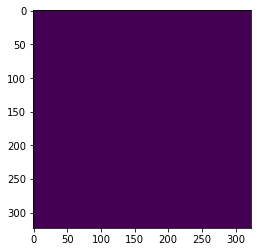

<AxesSubplot:>

In [10]:
from rasterio.plot import show
show((hls_ds['NIR1'].isnull().sum(dim='time') /len(hls_mask.time)) > 0.75, vmin=0, vmax=1)

In [11]:
hls_ds

<xarray.Dataset>
Dimensions:  (time: 25, y: 323, x: 323)
Coordinates:
  * time     (time) datetime64[ns] 2021-11-03 2021-11-07 ... 2022-06-06
  * x        (x) float64 5.176e+05 5.176e+05 5.176e+05 ... 5.272e+05 5.272e+05
  * y        (y) float64 4.524e+06 4.524e+06 4.524e+06 ... 4.515e+06 4.515e+06
Data variables:
    BLUE     (time, y, x) float64 dask.array<chunksize=(25, 100, 100), meta=np.ndarray>
    GREEN    (time, y, x) float64 dask.array<chunksize=(25, 100, 100), meta=np.ndarray>
    RED      (time, y, x) float64 dask.array<chunksize=(25, 100, 100), meta=np.ndarray>
    NIR1     (time, y, x) float64 dask.array<chunksize=(25, 100, 100), meta=np.ndarray>
    SWIR1    (time, y, x) float64 dask.array<chunksize=(25, 100, 100), meta=np.ndarray>
    SWIR2    (time, y, x) float64 dask.array<chunksize=(25, 100, 100), meta=np.ndarray>
    FMASK    (time, y, x) float64 dask.array<chunksize=(25, 100, 100), meta=np.ndarray>
    SZA      (time, y, x) float64 dask.array<chunksize=(25, 100, 100), meta=np.ndarray>
    SAA      (time, y, x) float64 dask.array<chunksize=(25, 100, 100), meta=np.ndarray>
    VZA      (time, y, x) float64 dask.array<chunksize=(25, 100, 100), meta=np.ndarray>
    VAA      (time, y, x) float64 dask.array<chunksize=(25, 100, 100), meta=np.ndarray>
    ATSA     (time, y, x) float64 dask.array<chunksize=(25, 100, 100), meta=np.ndarray>

In [12]:
#client.restart()

In [13]:
hls_ds = hls_ds.chunk({'time': 1, 'y': -1, 'x': -1})
print('   computing NDVI for available dates...')
t1 = time.time()
# create ndvi array
xr_ndvi = ndvi_func(hls_ds)#.compute()
xr_ndvi.name = 'NDVI'
print('...completed in ' + str(round(time.time() - t1, 0)) + ' secs')
print('total elasped time: ' + str(round((time.time() - t0)/60, 2)) + ' mins\n')

print('   computing biomass for available dates...')
t1 = time.time()
# create biomass array
xr_bm = hls_ds.map_blocks(pred_bm, template=hls_ds['NIR1'],
                          kwargs=dict(model=mod_bm)).where(hls_ds['NIR1'].notnull())#.compute()
xr_bm.name = 'Biomass'
print('...completed in ' + str(round(time.time() - t1, 0)) + ' secs')
print('total elasped time: ' + str(round((time.time() - t0)/60, 2)) + ' mins\n')

print('   computing biomass SE for available dates...')
t1 = time.time()
# create biomass array
xr_bm_se = hls_ds.map_blocks(pred_bm_se, template=hls_ds['NIR1'],
                          kwargs=dict(model=mod_bm)).where(hls_ds['NIR1'].notnull())#.compute()
xr_bm_se.name = 'Biomass_SE'
print('...completed in ' + str(round(time.time() - t1, 0)) + ' secs')
print('total elasped time: ' + str(round((time.time() - t0)/60, 2)) + ' mins\n')

print('   computing cover for available dates...')
t1 = time.time()
# create cover array
xr_cov = pred_cov(hls_ds, model=mod_cov).where(hls_ds['NIR1'].notnull())#.compute()
print('...completed in ' + str(round(time.time() - t1, 0)) + ' secs')
print('total elasped time: ' + str(round((time.time() - t0)/60, 2)) + ' mins\n')

#print('   removing dates with > 25% cloud cover...')
t1 = time.time()

#xr_ndvi = xr_ndvi.where(partial_mask, drop=True)
#xr_bm = xr_bm.where(partial_mask, drop=True)
#xr_bm_se = xr_bm_se.where(partial_mask, drop=True)
print('...completed in ' + str(round(time.time() - t1, 0)) + ' secs')
print('total elasped time: ' + str(round((time.time() - t0)/60, 2)) + ' mins\n')

   computing NDVI for available dates...
...completed in 0.0 secs
total elasped time: 0.02 mins

   computing biomass for available dates...
...completed in 0.0 secs
total elasped time: 0.02 mins

   computing biomass SE for available dates...
...completed in 0.0 secs
total elasped time: 0.02 mins

   computing cover for available dates...
...completed in 0.0 secs
total elasped time: 0.03 mins

...completed in 0.0 secs
total elasped time: 0.03 mins



In [17]:
print('   creating daily template for output...')
# reset date range to be within dataset
date_rng = date_rng[date_rng <= xr_ndvi['time'].max().values]

t1 = time.time()
# create an output Dataset template with all dates
dat_out = xr.Dataset(coords={'time': [x for x in date_rng if x not in xr_ndvi['time'].values],
                             'x': xr_ndvi.x,
                             'y': xr_ndvi.y})

   creating daily template for output...


In [18]:
dat_out_nans = np.zeros((dat_out.dims['time'], 
                         dat_out.dims['y'], 
                         dat_out.dims['x'])) * np.nan

In [19]:
dat_out = dat_out.assign(NDVI=(['time', 'y', 'x'],
                               dat_out_nans))

In [20]:
dat_out_ds = xr.concat([dat_out['NDVI'], xr_ndvi], dim='time').to_dataset()
dat_out_ds = dat_out_ds.sortby('time')
dat_out_ds = dat_out_ds.rio.write_crs(CRS.from_dict(init='epsg:32613'))

In [21]:
dat_out_ds

<xarray.Dataset>
Dimensions:      (time: 218, x: 323, y: 323)
Coordinates:
  * time         (time) datetime64[ns] 2021-11-01 2021-11-02 ... 2022-06-06
  * x            (x) float64 5.176e+05 5.176e+05 ... 5.272e+05 5.272e+05
  * y            (y) float64 4.524e+06 4.524e+06 ... 4.515e+06 4.515e+06
    spatial_ref  int64 0
Data variables:
    NDVI         (time, y, x) float64 dask.array<chunksize=(2, 294, 294), meta=np.ndarray>

In [22]:
yr_mask = dat_out_ds['time'].astype(np.datetime64).dt.year == yr

if not os.path.exists(os.path.join(outDIR, 'hls_ndvi/')):
    os.mkdir(os.path.join(outDIR, 'hls_ndvi/'))
if not os.path.exists(os.path.join(outDIR, 'hls_biomass/')):
    os.mkdir(os.path.join(outDIR, 'hls_biomass/'))
if not os.path.exists(os.path.join(outDIR, 'hls_cover/')):
    os.mkdir(os.path.join(outDIR, 'hls_cover/'))

In [23]:
dat_out_ds['NDVI_despike'] = despike_ts_xr(dat_out_ds['NDVI'].chunk(smth_chunks), 
                                           days_thresh=45,
                                           dat_thresh=0.07, 
                                           mask_outliers=False,
                                           iters=2,
                                           dims=['time'])
dat_out_ds['NDVI_smooth'] = smooth_xr(dat_out_ds['NDVI_despike'], 
                                      dims=['time'], 
                                      kwargs={'double': True, 'limit': 91})

dat_out_da = dat_out_ds.sel(time=yr_mask)['NDVI_smooth'].astype('float32').rio.reproject("EPSG:3857").compute()

dat_out_da.to_netcdf(
    os.path.join(outDIR, 'hls_ndvi/' + prefix + '_hls_ndvi_' + str(yr) + '.nc'))

#dat_out_ds = dat_out_ds.drop_vars([k for k in dat_out_ds.data_vars.keys() if 'NDVI' in k])
del dat_out_da
gc.collect()
client.restart()

/mnt/c/Users/TBGPEA-Sean/git_repos/hls_nrt/src/hls_funcs/smooth.py:182: RuntimeWarning: divide by zero encountered in double_scalars
  shadow_val = dat_diff / (dat_ts_cln[idx_post] - dat_ts_cln[idx_pre])
/mnt/c/Users/TBGPEA-Sean/git_repos/hls_nrt/src/hls_funcs/smooth.py:182: RuntimeWarning: divide by zero encountered in double_scalars
  shadow_val = dat_diff / (dat_ts_cln[idx_post] - dat_ts_cln[idx_pre])
/mnt/c/Users/TBGPEA-Sean/git_repos/hls_nrt/src/hls_funcs/smooth.py:182: RuntimeWarning: divide by zero encountered in double_scalars
  shadow_val = dat_diff / (dat_ts_cln[idx_post] - dat_ts_cln[idx_pre])
/mnt/c/Users/TBGPEA-Sean/git_repos/hls_nrt/src/hls_funcs/smooth.py:182: RuntimeWarning: divide by zero encountered in double_scalars
  shadow_val = dat_diff / (dat_ts_cln[idx_post] - dat_ts_cln[idx_pre])
/mnt/c/Users/TBGPEA-Sean/git_repos/hls_nrt/src/hls_funcs/smooth.py:182: RuntimeWarning: divide by zero encountered in double_scalars
  shadow_val = dat_diff / (dat_ts_cln[idx_post] - d

1500

In [24]:
dat_out = dat_out.rename({'NDVI': 'Biomass'})
dat_out_ds['Biomass'] = xr.concat([dat_out['Biomass'], xr_bm], dim='time')
dat_out_ds = dat_out_ds.sortby('time')

dat_out_ds['Biomass_despike'] = despike_ts_xr(dat_out_ds['Biomass'].chunk(smth_chunks),
                                              days_thresh=45,
                                              dat_thresh=150, 
                                              mask_outliers=True,
                                              z_thresh=5.0,
                                              iters=2,
                                              dims=['time'])
dat_out_ds['Biomass_smooth'] = smooth_xr(dat_out_ds['Biomass_despike'], 
                                         dims=['time'],
                                         kwargs={'double': True, 'limit': 91})

dat_out_da = dat_out_ds.sel(time=yr_mask)['Biomass_smooth'].astype('float32').rio.reproject("EPSG:3857").compute()
dat_out_da.to_netcdf(
    os.path.join(outDIR, 'hls_biomass/' + prefix + '_hls_bm_' + str(yr) + '.nc'))

#dat_out_ds = dat_out_ds.drop_vars([k for k in dat_out_ds.data_vars.keys() if 'Biomass' in k and 'SE' not in k])
del dat_out_da
gc.collect()
client.restart()

/mnt/c/Users/TBGPEA-Sean/git_repos/hls_nrt/src/hls_funcs/smooth.py:182: RuntimeWarning: divide by zero encountered in double_scalars
  shadow_val = dat_diff / (dat_ts_cln[idx_post] - dat_ts_cln[idx_pre])
/mnt/c/Users/TBGPEA-Sean/git_repos/hls_nrt/src/hls_funcs/smooth.py:182: RuntimeWarning: divide by zero encountered in double_scalars
  shadow_val = dat_diff / (dat_ts_cln[idx_post] - dat_ts_cln[idx_pre])
/mnt/c/Users/TBGPEA-Sean/git_repos/hls_nrt/src/hls_funcs/smooth.py:182: RuntimeWarning: divide by zero encountered in double_scalars
  shadow_val = dat_diff / (dat_ts_cln[idx_post] - dat_ts_cln[idx_pre])
/mnt/c/Users/TBGPEA-Sean/git_repos/hls_nrt/src/hls_funcs/smooth.py:182: RuntimeWarning: divide by zero encountered in double_scalars
  shadow_val = dat_diff / (dat_ts_cln[idx_post] - dat_ts_cln[idx_pre])
/mnt/c/Users/TBGPEA-Sean/git_repos/hls_nrt/src/hls_funcs/smooth.py:182: RuntimeWarning: divide by zero encountered in double_scalars
  shadow_val = dat_diff / (dat_ts_cln[idx_post] - d

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 16,Total memory: 15.50 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:44321,Workers: 8
Dashboard: http://127.0.0.1:8787/status,Total threads: 16
Started: 10 minutes ago,Total memory: 15.50 GiB
Comm: tcp://127.0.0.1:38093,Total threads: 2
Dashboard: http://127.0.0.1:43835/status,Memory: 1.94 GiB
Nanny: tcp://127.0.0.1:33079,


In [25]:
dat_out = dat_out.rename({'Biomass': 'Biomass_SE'})
dat_out_ds['Biomass_SE'] = xr.concat([dat_out['Biomass_SE'], xr_bm_se], dim='time')

dat_out_ds['Biomass_SE_despike'] = despike_ts_xr(dat_out_ds['Biomass_SE'].chunk(smth_chunks),
                                                 days_thresh=45,
                                                 dat_thresh=dat_out_ds['Biomass_SE'].std('time').mean().values * 3.0, 
                                                 mask_outliers=True,
                                                 z_thresh=5.0,
                                                 iters=2,
                                                 dims=['time'])
dat_out_ds['Biomass_SE_smooth'] = smooth_xr(dat_out_ds['Biomass_SE_despike'], 
                                         dims=['time'],
                                         kwargs={'double': True, 'limit': 91})

dat_out_da = dat_out_ds.sel(time=yr_mask)['Biomass_SE_smooth'].astype('float32').rio.reproject("EPSG:3857").compute()
dat_out_da.to_netcdf(
    os.path.join(outDIR, 'hls_biomass/' + prefix + '_hls_bm_se_' + str(yr) + '.nc'))

#dat_out_ds = dat_out_ds.drop_vars([k for k in dat_out_ds.data_vars.keys() if 'Biomass_SE' in k])
del dat_out_da
gc.collect()
client.restart()

/mnt/c/Users/TBGPEA-Sean/git_repos/hls_nrt/src/hls_funcs/smooth.py:182: RuntimeWarning: divide by zero encountered in double_scalars
  shadow_val = dat_diff / (dat_ts_cln[idx_post] - dat_ts_cln[idx_pre])
/mnt/c/Users/TBGPEA-Sean/git_repos/hls_nrt/src/hls_funcs/smooth.py:182: RuntimeWarning: divide by zero encountered in double_scalars
  shadow_val = dat_diff / (dat_ts_cln[idx_post] - dat_ts_cln[idx_pre])
/mnt/c/Users/TBGPEA-Sean/git_repos/hls_nrt/src/hls_funcs/smooth.py:182: RuntimeWarning: divide by zero encountered in double_scalars
  shadow_val = dat_diff / (dat_ts_cln[idx_post] - dat_ts_cln[idx_pre])
/mnt/c/Users/TBGPEA-Sean/git_repos/hls_nrt/src/hls_funcs/smooth.py:182: RuntimeWarning: divide by zero encountered in double_scalars
  shadow_val = dat_diff / (dat_ts_cln[idx_post] - dat_ts_cln[idx_pre])
/mnt/c/Users/TBGPEA-Sean/git_repos/hls_nrt/src/hls_funcs/smooth.py:182: RuntimeWarning: divide by zero encountered in double_scalars
  shadow_val = dat_diff / (dat_ts_cln[idx_post] - d

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 16,Total memory: 15.50 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:44321,Workers: 8
Dashboard: http://127.0.0.1:8787/status,Total threads: 16
Started: 15 minutes ago,Total memory: 15.50 GiB
Comm: tcp://127.0.0.1:43923,Total threads: 2
Dashboard: http://127.0.0.1:43007/status,Memory: 1.94 GiB
Nanny: tcp://127.0.0.1:33079,


In [26]:
c_prev = 'Biomass_SE'

for c in ['BARE', 'SD', 'GREEN', 'LITT']:
    print(c)
    dat_out = dat_out.rename({c_prev: c})
    dat_out_ds[c] = xr.concat([dat_out[c], xr_cov[c]], dim='time')
    
    dat_out_ds[c + '_despike'] = despike_ts_xr(dat_out_ds[c].chunk(smth_chunks),
                                               days_thresh=45,
                                               dat_thresh=0.3, 
                                               mask_outliers=True,
                                               z_thresh=5.0,
                                               iters=2,
                                               dims=['time'])
    dat_out_ds[c + '_smooth'] = smooth_xr(dat_out_ds[c + '_despike'], 
                                         dims=['time'],
                                         kwargs={'double': True, 'limit': 91})

    dat_out_da = dat_out_ds.sel(time=yr_mask)[c + '_smooth'].astype('float32').rio.reproject("EPSG:3857").compute()
    dat_out_da.to_netcdf(
        os.path.join(outDIR, 'hls_cover/' + prefix + '_hls_' + c + '_' + str(yr) + '.nc'))
    
    #dat_out_ds = dat_out_ds.drop_vars([k for k in dat_out_ds.data_vars.keys() if c in k])
    del  dat_out_da
    gc.collect()
    
    c_prev = c
    client.restart()

BARE


/mnt/c/Users/TBGPEA-Sean/git_repos/hls_nrt/src/hls_funcs/smooth.py:182: RuntimeWarning: invalid value encountered in double_scalars
  shadow_val = dat_diff / (dat_ts_cln[idx_post] - dat_ts_cln[idx_pre])
/mnt/c/Users/TBGPEA-Sean/git_repos/hls_nrt/src/hls_funcs/smooth.py:182: RuntimeWarning: divide by zero encountered in double_scalars
  shadow_val = dat_diff / (dat_ts_cln[idx_post] - dat_ts_cln[idx_pre])
/mnt/c/Users/TBGPEA-Sean/git_repos/hls_nrt/src/hls_funcs/smooth.py:182: RuntimeWarning: divide by zero encountered in double_scalars
  shadow_val = dat_diff / (dat_ts_cln[idx_post] - dat_ts_cln[idx_pre])
/mnt/c/Users/TBGPEA-Sean/git_repos/hls_nrt/src/hls_funcs/smooth.py:182: RuntimeWarning: invalid value encountered in double_scalars
  shadow_val = dat_diff / (dat_ts_cln[idx_post] - dat_ts_cln[idx_pre])
/mnt/c/Users/TBGPEA-Sean/git_repos/hls_nrt/src/hls_funcs/smooth.py:182: RuntimeWarning: divide by zero encountered in double_scalars
  shadow_val = dat_diff / (dat_ts_cln[idx_post] - dat

SD


/mnt/c/Users/TBGPEA-Sean/git_repos/hls_nrt/src/hls_funcs/smooth.py:182: RuntimeWarning: invalid value encountered in double_scalars
  shadow_val = dat_diff / (dat_ts_cln[idx_post] - dat_ts_cln[idx_pre])
/mnt/c/Users/TBGPEA-Sean/git_repos/hls_nrt/src/hls_funcs/smooth.py:182: RuntimeWarning: divide by zero encountered in double_scalars
  shadow_val = dat_diff / (dat_ts_cln[idx_post] - dat_ts_cln[idx_pre])
/mnt/c/Users/TBGPEA-Sean/git_repos/hls_nrt/src/hls_funcs/smooth.py:145: RuntimeWarning: divide by zero encountered in true_divide
  modified_z_scores = 0.6745 * (ts - median_int) / mad_int
/mnt/c/Users/TBGPEA-Sean/git_repos/hls_nrt/src/hls_funcs/smooth.py:145: RuntimeWarning: invalid value encountered in true_divide
  modified_z_scores = 0.6745 * (ts - median_int) / mad_int
/mnt/c/Users/TBGPEA-Sean/git_repos/hls_nrt/src/hls_funcs/smooth.py:182: RuntimeWarning: invalid value encountered in double_scalars
  shadow_val = dat_diff / (dat_ts_cln[idx_post] - dat_ts_cln[idx_pre])
/mnt/c/Users/

GREEN


/mnt/c/Users/TBGPEA-Sean/git_repos/hls_nrt/src/hls_funcs/smooth.py:182: RuntimeWarning: invalid value encountered in double_scalars
  shadow_val = dat_diff / (dat_ts_cln[idx_post] - dat_ts_cln[idx_pre])
/mnt/c/Users/TBGPEA-Sean/git_repos/hls_nrt/src/hls_funcs/smooth.py:182: RuntimeWarning: invalid value encountered in double_scalars
  shadow_val = dat_diff / (dat_ts_cln[idx_post] - dat_ts_cln[idx_pre])
/mnt/c/Users/TBGPEA-Sean/git_repos/hls_nrt/src/hls_funcs/smooth.py:182: RuntimeWarning: invalid value encountered in double_scalars
  shadow_val = dat_diff / (dat_ts_cln[idx_post] - dat_ts_cln[idx_pre])
/mnt/c/Users/TBGPEA-Sean/git_repos/hls_nrt/src/hls_funcs/smooth.py:182: RuntimeWarning: divide by zero encountered in double_scalars
  shadow_val = dat_diff / (dat_ts_cln[idx_post] - dat_ts_cln[idx_pre])
/mnt/c/Users/TBGPEA-Sean/git_repos/hls_nrt/src/hls_funcs/smooth.py:182: RuntimeWarning: divide by zero encountered in double_scalars
  shadow_val = dat_diff / (dat_ts_cln[idx_post] - dat_

LITT


/mnt/c/Users/TBGPEA-Sean/git_repos/hls_nrt/src/hls_funcs/smooth.py:145: RuntimeWarning: divide by zero encountered in true_divide
  modified_z_scores = 0.6745 * (ts - median_int) / mad_int
/mnt/c/Users/TBGPEA-Sean/git_repos/hls_nrt/src/hls_funcs/smooth.py:145: RuntimeWarning: invalid value encountered in true_divide
  modified_z_scores = 0.6745 * (ts - median_int) / mad_int
/mnt/c/Users/TBGPEA-Sean/git_repos/hls_nrt/src/hls_funcs/smooth.py:182: RuntimeWarning: invalid value encountered in double_scalars
  shadow_val = dat_diff / (dat_ts_cln[idx_post] - dat_ts_cln[idx_pre])
/mnt/c/Users/TBGPEA-Sean/git_repos/hls_nrt/src/hls_funcs/smooth.py:182: RuntimeWarning: divide by zero encountered in double_scalars
  shadow_val = dat_diff / (dat_ts_cln[idx_post] - dat_ts_cln[idx_pre])
/mnt/c/Users/TBGPEA-Sean/git_repos/hls_nrt/src/hls_funcs/smooth.py:182: RuntimeWarning: invalid value encountered in double_scalars
  shadow_val = dat_diff / (dat_ts_cln[idx_post] - dat_ts_cln[idx_pre])
/mnt/c/Users/